In [4]:
import sys
import distributed
import numpy as np
import astropy.io.fits
import astropy.time
import matplotlib.pyplot as plt
from datetime import datetime as dt_obj
import matplotlib.dates

sys.path.append('../scripts')
from drms_on_ames import Client

%matplotlib inline

ModuleNotFoundError: No module named 'drms_on_ames'

# Calculating SHARP Features with Dask

## Will Barnes, Monica Bobra

One of the data products released by the Solar Dynamics Observatory (SDO) is called [Space-weather HMI Active Region Patches](http://link.springer.com/article/10.1007%2Fs11207-014-0529-3), or SHARPs. The SHARP data series include patches of vector magnetic field data, or all three components of the surface magnetic field, taken by the Helioseismic and Magnetic Imager (HMI) instrument on SDO. These patches encapsulate active regions, which are both automatically detected and tracked as they cross the solar disk. The SHARP data series also includes a bitmap array, called `bitmap`, which encodes the membership of any given pixel in an active region. Another bitmap, called `conf_disambig`, describes the confidence in the azimuthal component of the magnetic field vector for each pixel. 

The SHARP data seres also include keywords, as metadata, that describe various physical parameters of solar active regions; for example, the total unsigned flux within an active region at a time T. This allows users to automatically flux emergence over time per active region without using the image data at all. 

Figure 3 of [Bobra et al. (2014)](http://link.springer.com/article/10.1007%2Fs11207-014-0529-3) and [this code](https://github.com/mbobra/calculating-spaceweather-keywords/blob/master/calculate_swx_fits.py) details which of the pixels in any given magnetic field map contribute to these active region parameters. Generally speaking, only pixels within some coherent magnetic structure and pixels with a robust disambiguation result contribute to an active region parameter.

However, the term **active region** does not have an exact definition. NOAA, for example, uses photometric sunspot data to identify active regions, whereas the SHARP series uses magnetic field data to identify active regions. As a result, the SHARP data series contains more active regions than the NOAA active region database because it captures small regions without any associated photometric signal. One might want to define an active region in yet another, different way or caculate the physical parameters based on yet another, different selection criteria. 

In this notebook, we will calculate physical parameters of solar active regions directly from the magnetic field maps in the SHARP data series using different selection criteria than those in the SHARP data series. We will demonstrate that different selection criteria result in slightly different physical parameters, although the general trending behavior is the same. 

However, re-calculating multiple physical parameters on 10 years of active region data, which inclues 2.7 million image arrays, requires significant computational resources and parallelization techniques. We will demonstrate how to do this efficiently using both the resources of the NASA Ames Pleiades supercomputer and a Python package for parallelization called [Dask](https://dask.org/).

## Query SHARP Series

First, query the SHARP data series for both metadata (stored in `sharp_keys`) and image data (stored in `sharp_segs`) for a 7 day period. In the query below, `377` is an internal reference to the active region number; this corresponds to NOAA Active Region 11158. The internal active region number is stored in the key `HARPNUM` and the NOAA active region number is stored in the key `NOAA_ARS`.

In [2]:
client = Client(ssh=True)

In [3]:
sharp_keys = [
    'T_REC',
    'CDELT1',
    'RSUN_REF',
    'RSUN_OBS',
    'DSUN_OBS',
    'USFLUX',
    'ERRVF',
    'CMASK'
    'NOAA_ARS',
]
sharp_segs = [
    'Br',
    'Bp',
    'Bt',
    'Br_err',
    'Bp_err',
    'Bt_err',
    'bitmap',
    'conf_disambig',
]

In [11]:
keys,segs = client.query(
    'hmi.sharp_cea_720s[377][2011.02.13/7d]',
    key=sharp_keys,
    seg=sharp_segs,
)

The `keys` table contains all of the requested keywords for each `T_REC` value and the `segs` table contains each requested segment at each `T_REC`. Note that the path returned for each segment is a path on the Pleidades filesystem, not the usual `SUMS` directory.

In [12]:
keys[:3]

T_REC  CDELT1   RSUN_REF    RSUN_OBS      DSUN_OBS  \
0  2011.02.14_15:00:00_TAI    0.03  696000000  971.866150  1.477167e+11   
1  2011.02.14_15:12:00_TAI    0.03  696000000  971.876404  1.477151e+11   
2  2011.02.14_15:24:00_TAI    0.03  696000000  971.886658  1.477136e+11   

         USFLUX         ERRVF    CMASK  
0  2.429176e+22  5.809020e+18  40397.0  
1  2.423040e+22  5.767523e+18  40148.0  
2  2.438431e+22  5.800516e+18  40407.0

In [13]:
segs[-3:]

Br  \
117  /nobackup/drms/SUM2/D1043273036/S00000/Br.fits   
118  /nobackup/drms/SUM3/D1043273118/S00000/Br.fits   
119  /nobackup/drms/SUM1/D1043273176/S00000/Br.fits   

                                                 Bp  \
117  /nobackup/drms/SUM2/D1043273036/S00000/Bp.fits   
118  /nobackup/drms/SUM3/D1043273118/S00000/Bp.fits   
119  /nobackup/drms/SUM1/D1043273176/S00000/Bp.fits   

                                                 Bt  \
117  /nobackup/drms/SUM2/D1043273036/S00000/Bt.fits   
118  /nobackup/drms/SUM3/D1043273118/S00000/Bt.fits   
119  /nobackup/drms/SUM1/D1043273176/S00000/Bt.fits   

                                                Br_err  \
117  /nobackup/drms/SUM2/D1043273036/S00000/Br_err....   
118  /nobackup/drms/SUM3/D1043273118/S00000/Br_err....   
119  /nobackup/drms/SUM1/D1043273176/S00000/Br_err....   

                                                Bp_err  \
117  /nobackup/drms/SUM2/D1043273036/S00000/Bp_err....   
118  /nobackup/drms/SUM3/D1043273118/S00000/Bp_err....   
119  /nobackup/drms/SUM1/D1043273176/S00000/Bp_err....   

                                                Bt_err  \
117  /nobackup/drms/SUM2/D1043273036/S00000/Bt_err....   
118  /nobackup/drms/SUM3/D1043273118/S00000/Bt_err....   
119  /nobackup/drms/SUM1/D1043273176/S00000/Bt_err....   

                                                bitmap  \
117  /nobackup/drms/SUM2/D1043273036/S00000/bitmap....   
118  /nobackup/drms/SUM3/D1043273118/S00000/bitmap....   
119  /nobackup/drms/SUM1/D1043273176/S00000/bitmap....   

                                         conf_disambig  
117  /nobackup/drms/SUM2/D1043273036/S00000/conf_di...  
118  /nobackup/drms/SUM3/D1043273118/S00000/conf_di...  
119  /nobackup/drms/SUM1/D1043273176/S00000/conf_di...

## Data Pipeline

We want to calculate a SHARP feature, the absolute flux, at each timestep, using the data from each of the requested segments.

First, we need to read in the data and calculate a few intermediate quantities. We'll do this in a function called `prep_data`

In [14]:
def prep_data(i):
    bz = astropy.io.fits.getdata(segs['Br'][i])
    bz_err = astropy.io.fits.getdata(segs['Br_err'][i])
    conf_disambig = astropy.io.fits.getdata(segs['conf_disambig'][i])
    bitmap = astropy.io.fits.getdata(segs['bitmap'][i])
    rsun_ref = keys.RSUN_REF[i]
    rsun_obs = keys.RSUN_OBS[i]
    cdelt1 = keys.CDELT1[i]
    dsun_obs = keys.DSUN_OBS[i]
    radsindeg = np.pi/180.
    cdelt1_arcsec = (np.arctan((rsun_ref*cdelt1*radsindeg)/(dsun_obs)))*(1/radsindeg)*(3600.)
    return bz, bz_err, conf_disambig, bitmap, rsun_ref, rsun_obs, cdelt1_arcsec

For the case shown here, we'll calculate the total unsigned flux,

$$
\Phi = \sum |B_z|\mathrm{d}\,A
$$

For more information, see Table 3 of [Bobra et al. (2015)](https://doi.org/10.1007/s11207-014-0529-3). See [this repository](https://github.com/mbobra/calculating-spaceweather-keywords) for more details about how to calculate SHARP features in Python.

In [15]:
def unsigned_flux(bz, bz_err, conf_disambig, bitmap, rsun_ref, rsun_obs, cdelt1_arcsec):
    """
    This function computes the total unsigned flux in units of G/cm^2.
    It also returns the number of pixels used in this calculation in the keyword CMASK.
    
    To compute the unsigned flux, we simply calculate
       flux = surface integral [(vector Bz) dot (normal vector)],
            = surface integral [(magnitude Bz)*(magnitude normal)*(cos theta)].

    However, since the field is radial, we will assume cos theta = 1.
    Therefore, the pixels only need to be corrected for the projection.

    To convert G to G*cm^2, simply multiply by the number of square centimeters per pixel: 
       (Gauss/pix^2)(CDELT1)^2(RSUN_REF/RSUN_OBS)^2(100.cm/m)^2
       =Gauss*cm^2
    """
    mask = np.logical_or(bitmap < 30, np.isnan(bz))
    Bz_sum = np.abs(bz[~mask]).sum()
    Bz_err = (bz_err[~mask]**2).sum()
    mask_count = (~mask).sum()
    
    factor = (cdelt1_arcsec*(rsun_ref/rsun_obs)*100.0)**2
    mean_vf = Bz_sum*factor
    mean_vf_err = np.sqrt(Bz_err)*np.abs(factor)
    
    return mean_vf, mean_vf_err, mask_count


## Mapping across `T_REC` with Dask

First, setup the Dask cluster. For this simple example, we'll just use a `LocalCluster` (i.e. all the cores on a single machine). However, this could generalize to larger clusters as well

In [16]:
cluster = distributed.LocalCluster()

In [17]:
dask_client = distributed.Client(cluster)

Next, we want to map our data preparation function to each row in our key and segment table to extract the features of interest.

In [18]:
prepped_data = dask_client.map(
    prep_data,
    range(len(keys))
)

Lastly, we'll pass our list of prepared data to our function which will actually do the unsigned flux calculation. The "lambda" function just unwraps the list returned by `prep_data`.

In [19]:
features = dask_client.map(
    lambda x: unsigned_flux(*x),
    prepped_data,
)

## Plotting the results
Now, pull out some of the values and plot them as a function of time!  

The plot below shows the total unsigned flux, calculated in two different ways, for NOAA active region 11158 between 13 February 2011 and 20 February 2011. This active region produced an X2.2-class flare on 15 February 2011 at 01:56 UT.  

The original calculation (plotted in orange) selected pixels that satisfied two criteria: `conf_disambig[j,i]` must be > 70 and `bitmap[j,i]` must be > 30. For the modified calculation (plotted in blue), we dropped the first criteria. Since we're summing over more pixels, the modified calculation has higher values, but the same general trending behavior.

In [1]:
def parse_tai_string(tstr,datetime=True):
    year   = int(tstr[:4])
    month  = int(tstr[5:7])
    day    = int(tstr[8:10])
    hour   = int(tstr[11:13])
    minute = int(tstr[14:16])
    if datetime: return dt_obj(year,month,day,hour,minute)
    else: return year,month,day,hour,minute

In [2]:
t_rec = np.array([parse_tai_string(keys.T_REC[i],datetime=True) for i in range(keys.T_REC.size)])

NameError: name 'np' is not defined

In [20]:
mean_vf = np.array([f.result()[0] for f in features])
mean_vf_err = np.array([f.result()[1] for f in features])

NameError: name 't_rec' is not defined

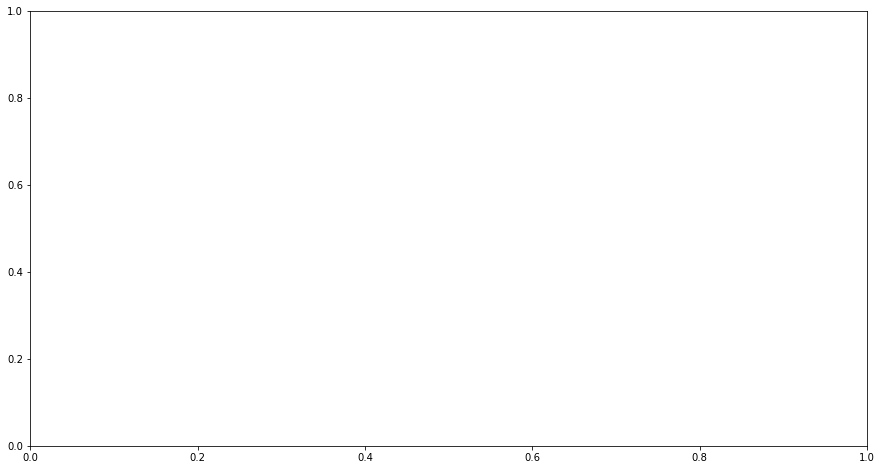

In [5]:
fig, ax = plt.subplots(figsize=(16,8))

# define some colors
orangered = (1.0,0.27,0,1.0)                # create an orange-red color
cornblue  = (0.39,0.58,0.93,1.0)            # create an cornflower blue color

# ascribe the data to the axes
# original calculation of total unsigned flux
ax.plot(t_rec, (keys.USFLUX)/(1e22),'o', color=orangered, label='Original calculation of total unsigned flux')
ax.errorbar(t_rec, (keys.USFLUX)/(1e22), yerr=(keys.ERRVF)/(1e22), linestyle='', color=orangered)

# new calculation of total unsigned flux
ax.plot(t_rec,mean_vf/(1e22), 'o', color=cornblue, label='Modified calculation of total unsigned flux')
ax.errorbar(t_rec, mean_vf/(1e22), yerr=(mean_vf_err)/(1e22), linestyle='', color=cornblue)

# format the x-axis with universal time
locator = AutoDateLocator()
locator.intervald[DAILY] = [1] # show every day
formatter = DateFormatter('%b %d')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# label the axes and the plot
ax.set_xlabel('Time in UT',**text_style)
ax.set_ylabel('Maxwells x 1e22',**text_style)
ax.set_title('Total Unsigned Flux Starting at '+str(t_rec[0])+' UT') # annotate the plot with a start time

# format the legend
legend = plt.legend(loc='upper right', fontsize=12, framealpha=0.0,title='')
legend.get_frame().set_linewidth(0.0)